In [2]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt

# Climate Box Models
Hey UROPs! As you walk through this notebook, we'll be going through progressively more complex (though overall still simple) examples of box models that describe temperature change in the climate system. The final example is roughly calibrated to the actual climate, so you'll get a decent picture of how the global mean temperature actually responds to increasing emissions!

Also to address the generative elephAInt in the room, ChatGPT or Gemini will give you a solution to this notebook very quickly. I'd recommend using it only to help with programming if you get stuck on that, as you'll only be hurting your own understanding by using it to complete the science part of this notebook. Instead, feel free to come ask me questions (my office is 54-1320) or shoot me an email if you get stuck on the science/math!

## 0. Primer on Numerically Solving ODEs
Before we jump into the actual box model, we need to briefly cover how to solve ordinary differential equations (ODEs) using a computer, which you may or may not have seen before. It's a bit different than the stuff covered in 18.03, since that classes focuses a lot on methods to find analytic solutions to ODEs, which we may not have access to in a real problem (even if we do have an analytic solution, the form might be terrible to work with). To start, we'll implement the most simple method to solve an ODE: forward Euler. We'll be using this method to make our box models later in the notebook.

### 0.1 The Forward Euler Method

The forward Euler method is one of the most straightforward numerical techniques for solving ODEs, and you may have already seen it in a calculus class. The core idea is to approximate the solution at the next time step by taking a small step from the current point in the direction of the tangent line.

Given an equation of the form $\frac{dy}{dt} = f(t,y)$, we can find the next value, $y_{n+1}$, from the current value, $y_n$, using the formula:
\begin{align}
y_{n+1} = y_n + \Delta t f(t_n, y_n),
\end{align} where $\Delta t$ is the size of the time step.

In the cell below, you'll find the skeleton code for a forward Euler scheme applied to a simple exponential growth ODE. This ODE is given by $\frac{dy}{dt} = ry$. You'll need to implement forward Euler as described above and plot it against the analytic solution - bonus point, take a quick minute to derive the analytic solution yourself! There aren't grades for this UROP, but it's a good exercise :)

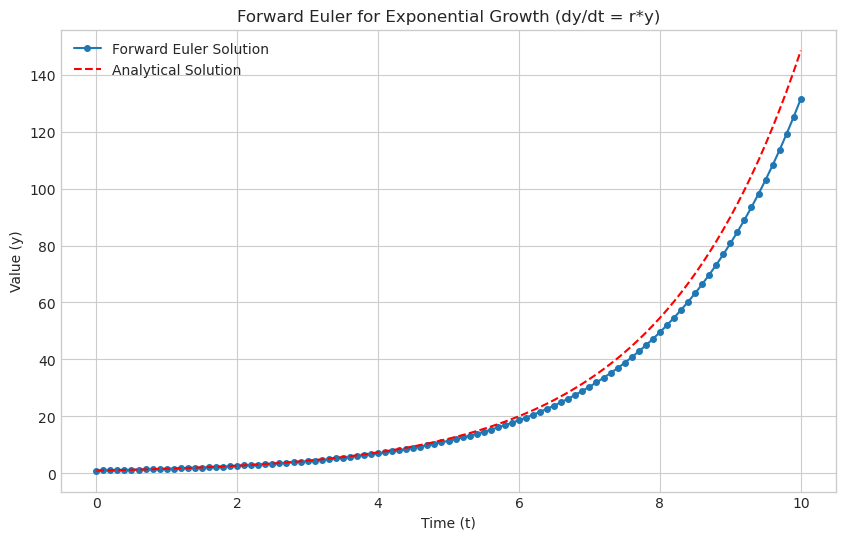

In [5]:
# --- Problem Definition ---
# The differential equation for exponential growth: dy/dt = r * y
def exponential_growth_ode(y, r):
    return r * y

# --- Parameters ---
r = 0.5          # Growth rate
y0 = 1.0         # Initial condition at t=0
T = 10.0         # Total time to integrate
dt = 0.1         # Time step size

# --- Integration Setup ---
n_steps = int(T / dt)
t = np.linspace(0, T, n_steps + 1)
y_numerical = np.zeros(n_steps + 1)

# Set initial condition
y_numerical[0] = y0

# --- Forward Euler Integration Loop ---
for i in range(n_steps):
    y_numerical[i+1] = y_numerical[i] + dt * exponential_growth_ode(y_numerical[i], r)

# --- Analytical Solution for Comparison ---
# Analytical solution: y(t) = y0 * exp(r*t)
y_analytical = y0 * np.exp(r * t)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, y_numerical, 'o-', label='Forward Euler Solution', markersize=4)
ax.plot(t, y_analytical, 'r--', label='Analytical Solution')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Value (y)')
ax.set_title('Forward Euler for Exponential Growth (dy/dt = r*y)')
ax.legend()
plt.show()

### 0.2 Numerical Stability (just for fun)
While simple to implement, the main drawback of forward Euler is its conditional stability: $\Delta t$ must be sufficiently small relative to the fastest dynamics of the system, otherwise the numerical solution can become unstable and diverge wildly from the true solution. To overcome this, more advanced and stable time-stepping schemes exist, such as the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), which increase accuracy by evaluating the function f(t,y) at multiple points within each time step. This provides a better-weighted average of the slope and allows for larger, more efficient time steps.

In the cell below, implement forward Euler again but for a "stiff" ODE. A stiff equation is one where the system is unstable unless the chosen timestep is super small. I've also given you an implementation of the 4th order Runge-Kutta scheme which has no issues solving this stiff problem. Feel free to play around with the timestep to see how it impacts each solver - when does RK4 go unstable?

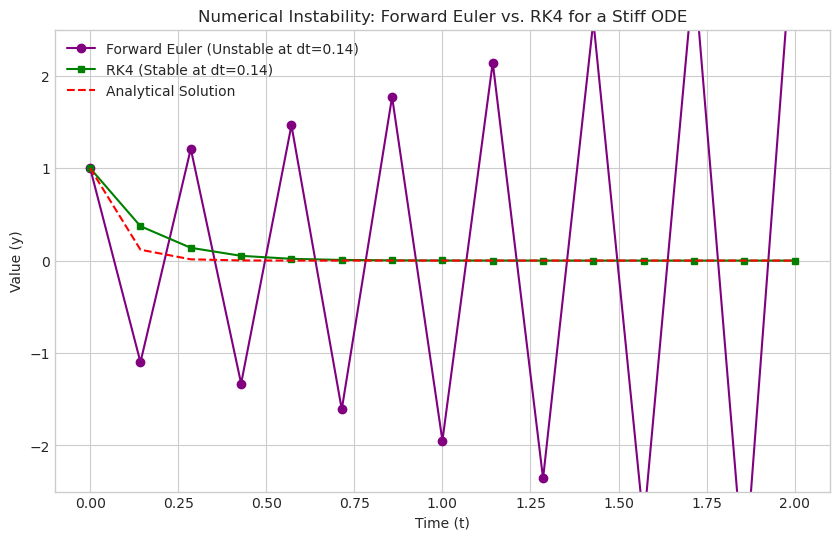

In [16]:
# --- Problem Definition ---
# A "stiff" ordinary differential equation
# dy/dt = -k * y
def stiff_ode(y, k=15):
    return -k * y

# --- Parameters ---
k = 15.0         # A large constant making the ODE stiff
y0 = 1.0         # Initial condition at t=0
T = 2.0          # Total time to integrate
dt = 0.14        # Stability limit is 2/15 or about 0.133. This is just above it.

# --- Integration Setup ---
n_steps = int(T / dt)
t = np.linspace(0, T, n_steps + 1)
y_fe = np.zeros(n_steps + 1)
y_rk4 = np.zeros(n_steps + 1)
y_fe[0] = y0
y_rk4[0] = y0

# --- Integration Loops ---

# 1. Forward Euler (expected to be unstable)
for i in range(n_steps):
    y_fe[i+1] = y_fe[i] + dt * stiff_ode(y_fe[i], k)

# 2. 4th-Order Runge-Kutta (RK4)
for i in range(n_steps):
    k1 = stiff_ode(y_rk4[i], k)
    k2 = stiff_ode(y_rk4[i] + 0.5 * dt * k1, k)
    k3 = stiff_ode(y_rk4[i] + 0.5 * dt * k2, k)
    k4 = stiff_ode(y_rk4[i] + dt * k3, k)
    y_rk4[i+1] = y_rk4[i] + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# --- Analytical Solution for Comparison ---
y_analytical = y0 * np.exp(-k * t)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, y_fe, 'o-', label=f'Forward Euler (Unstable at dt={dt})', color='purple')
ax.plot(t, y_rk4, 's-', label=f'RK4 (Stable at dt={dt})', color='green', markersize=4)
ax.plot(t, y_analytical, 'r--', label='Analytical Solution')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Value (y)')
ax.set_title('Numerical Instability: Forward Euler vs. RK4 for a Stiff ODE')
ax.set_ylim(-2.5, 2.5) # Zoom in to see the instability clearly
ax.legend()
plt.show()

## 1. Intro to Box Models
Climate box models are simplified representations of the Earth's climate system. They divide the system into a series of interconnected "boxes," each representing a different component like the atmosphere, land, or ocean. These models are useful for understanding fundamental climate dynamics without the complexity of high-resolution global climate models. You can find a [super short description here](https://www.cmich.edu/docs/default-source/colleges/college-of-liberal-arts-and-social-sciences/cmich-press/20210420_what_is_a_box_model95eb1090-9830-4eb3-ad04-671d23c3c27e.pdf?sfvrsn=887e760a_7), a [slightly more in-depth description here](https://www.ebsco.com/research-starters/science/box-models), and a [full paper on them here](https://pmc.ncbi.nlm.nih.gov/articles/PMC2871910/) (I'd recommend just skimming this one to get the big ideas).

There are many types of box models (e.g. you can have a box model for the entire carbon cycle, or one that just represents some processes within the ocean), and we'll be focusing on temperature, since that's what's most relevant to our emulator work. The governing equation for our box model is:
\begin{align}
c(x)\frac{\partial T(x,t)}{\partial t} = -\lambda(x) T(x,t) + R(t) + \nabla \cdot \mathbf{F}(x,t),
\end{align}
where $c(x)$ is the regional heat capacity, $T(x,t)$ is the regional temperature, $\lambda$ is the regional feedback parameter, $R(t)$ is the forcing, and $\nabla \cdot \mathbf{F}(x,t)$ is the heat flux divergence. Let's walk through these conceptually.

### 1.1. Physics of the Climate
The Earth's climate is governed by a balance between incoming solar radiation (energy in) and outgoing longwave (thermal) radiation (energy out). When the climate is in equilibrium, these two energy fluxes are equal. A climate forcing (like an increase in greenhouse gases, represented here by $R(t)$) disrupts this balance by trapping some of the outgoing radiation, creating an energy imbalance where energy in exceeds energy out.

The planet must warm up to restore balance. As the Earth's surface temperature increases, it radiates more energy to space, attempting to close the energy gap. The climate feedback parameter, $\lambda$, quantifies exactly how effectively the climate system radiates this excess energy away for a given amount of warming. If $\lambda$ is large, it means the climate system is very efficient at shedding extra heat, and only a small amount of warming is needed to restore energy balance after a forcing. Conversely, if $\lambda$ is small, the system is less efficient at radiating heat away, and a much larger temperature increase is required to re-establish equilibrium. We allow this parameter to vary by region in our model, for example, representing how land might be more or less effective at getting rid of that excess energy than the ocean.

However, as the temperature response might be very different in different regions of the world, we also need a way to represent how heat transfers within the Earth system - our heat flux divergence term. This term aggregates processes like advection diffusion and allows the different boxes to "talk" to each other; if we don't have this term, then we're effectively simulating three separate planets that have uniform feedbacks. For our models, we'll assume the flux divergence is a purely diffusive process given by,
\begin{align}
\nabla \cdot \mathbf{F}(x,t) = D\left(T(x_{i+1},t) - T(x_i,t)\right),
\end{align}
where the subscripts indicate which box we're in. If you write these equations out for a three box model, you'll find that boxes 1 and 3 only communicate with box 2 and not each other, representing how the top layer of the ocean facilitates communication between the atmosphere and deep ocean.

## 2. One Box Model
In the simplest case, we have a single box representing the entire climate system. There is no heat exchange with other components, so the diffusive term is zero. Our equation simplifies to,
\begin{align}
c\frac{dT}{dt} = -\lambda T + R(t).
\end{align}

In the cell below, you'll be filling in code to run this one box model, integrating it using the forward Euler method. I chose the parameters in a somewhat ad-hoc manner, but it's somewhat equivalent to a shallow ocean planet.

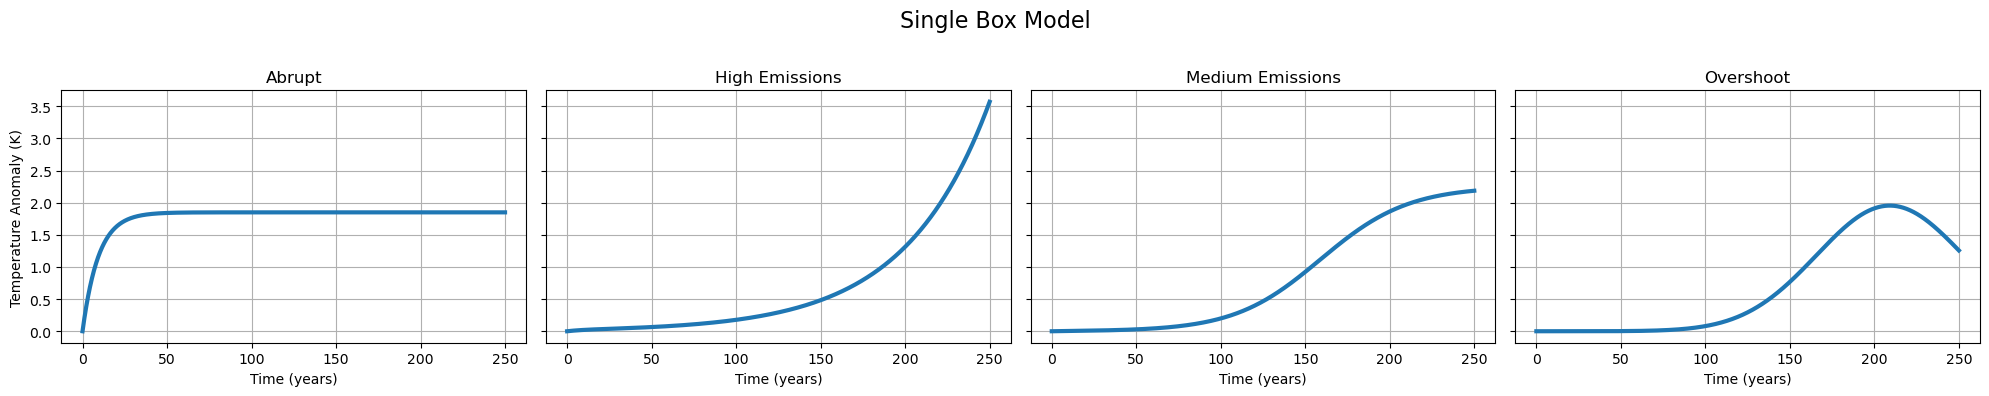

In [29]:
# --- Model Parameters ---
lam = 2.0  # Climate feedback parameter (W m-2 K-1)
rho_w = 1e3 # Water density (kg m-3)
cp_w = 4e3 # Water specific heat capacity (J kg-1 K-1)
h = 150 # Water slab thickness (m)
sec_per_year = 3.154e7
C = h * rho_w * cp_w / sec_per_year 

# --- Time Integration ---
dt = 0.1  # Time step (years)
t = np.arange(0, 250 + dt, dt)

# --- Forcing Scenarios ---
# 1. Abrupt, constant forcing
f0 = 3.7  # Forcing amplitude
f_abrupt = np.full_like(t, f0)

# 2. High emissions, exponential forcing
f_exp = 8.5/(np.exp(250/50))*np.exp(t/50)

# 3. Medium emissions, tanh profile
beta = 1/50 # Transition time
f_med = 2.25 + 2.25*np.tanh(beta*(t - 150))/np.tanh(250*beta)

# 4. Overshoot, Gaussian profile
a = 4 # Forcing amplitude
b = 200 # Peak year
c = 42.47 # Growth rate
f_over = a * np.exp(-np.power(t - b,2)/(2 * c**2))

forcings = [f_abrupt, f_exp, f_med, f_over]
titles = ['Abrupt', 'High Emissions', 'Medium Emissions', 'Overshoot']

# --- Single Box Simulation ---
T = np.zeros_like(t)
results_single = []

for f in forcings:
    T_scenario = np.zeros_like(t)
    for i in range(1, len(t)):
        T_scenario[i] = T_scenario[i-1] + dt * (-lam/C * T_scenario[i-1] + f[i-1] / C)
    results_single.append(T_scenario)

# --- Plotting ---
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
for i in range(4):
    axes[i].plot(t, results_single[i], lw=3)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Time (years)')
    if i == 0:
        axes[i].set_ylabel('Temperature Anomaly (K)')
    axes[i].grid(True)
plt.suptitle('Single Box Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. Three Box Model (Uncoupled)
Now, let's expand our model to three boxes representing the land/atmosphere, the shallow ocean, and the deep ocean. Initially, these boxes will be "uncoupled," meaning there is no heat exchange between them ($D=0$).

The equations for the three boxes are:
\begin{align}
c_{atm}\frac{dT_{atm}}{dt} &= -\lambda_{atm} T_{atm} + R(t),\\
c_{shallow}\frac{dT_{shallow}}{dt} &= -\lambda_{shallow} T_{shallow} + R(t),\\
c_{deep}\frac{dT_{deep}}{dt} &= -\lambda_{deep} T_{deep} + R(t),
\end{align}
where "atm" refers to the atmosphere, "shallow" refers to the top layer of the ocean, and "deep" refers to the deep ocean.

For the case when we have multiple boxes, it makes more sense to bring some linear algebra into our work to simply things - I promise it makes the work a LOT easier, it may just take some getting used to. We choose to represent our system with a linear operator, $\mathcal{L}$, acting on our variable of interest, now written as a matrix:
\begin{align}
\frac{d\mathbf{T}}{dt} &= \mathcal{L} \mathbf{T} + c^{-1}R(t),
\end{align}
where
\begin{align}
\mathcal{L} =
\begin{pmatrix}
-\lambda_{atm}/c_{atm} & 0 & 0\\
0 & -\lambda_{shallow}/c_{shallow} & 0\\
0 & 0 & -\lambda_{deep}/c_{deep}
\end{pmatrix}
\end{align}

This is functionally the same as the previous case, but now with three independent systems. Any off-diagonal terms in $\mathcal{L}$ would represent interactions between layers, as we'll see in the next case. In the cell below, you'll be filling in code to implement the uncoupled three box model using some linear algebra.

Qualitatively, how do the three boxes differ?

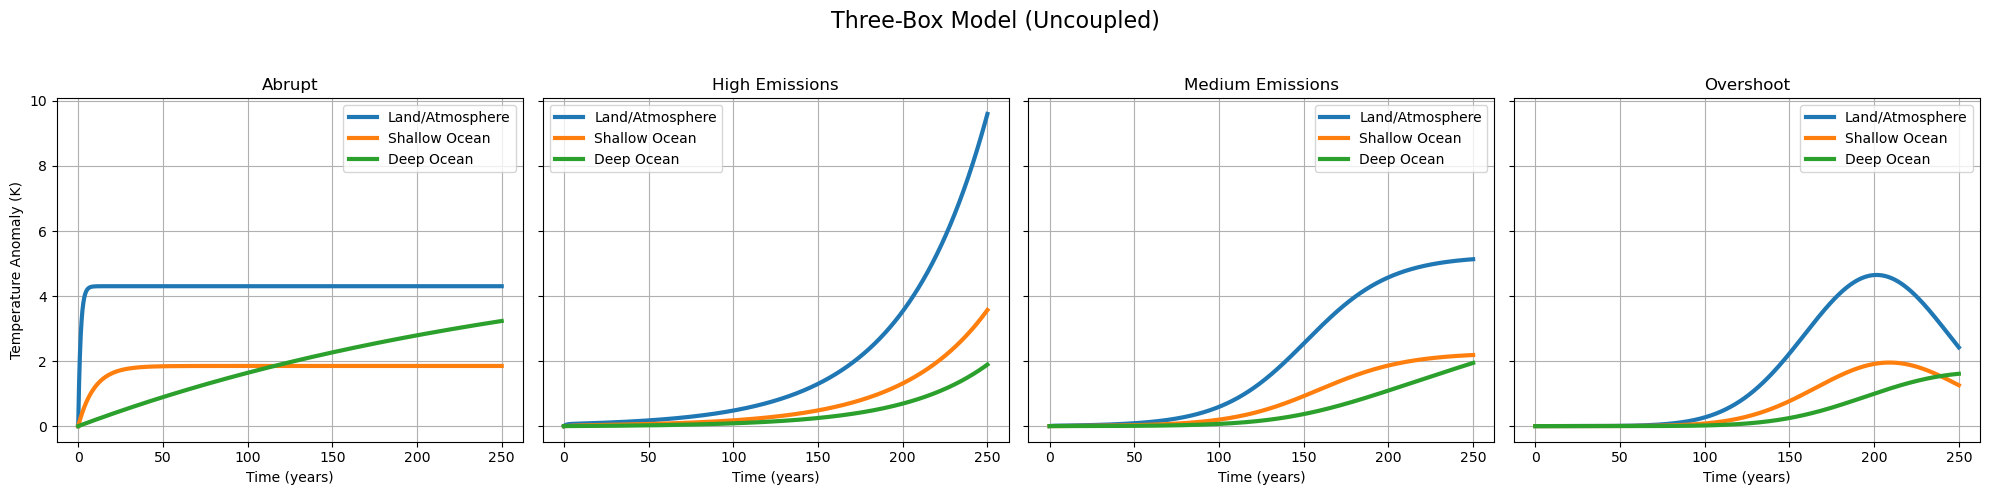

In [51]:
# --- Model Parameters for Three Boxes ---
# Climate feedback parameters (W m-2 K-1)
lam_uncoupled = np.array([0.86, 2.0, 0.67])

# Heat capacities (J/K/m^2)
h = np.array([10, 150, 1500])
C_uncoupled = h * rho_w * cp_w / sec_per_year 

# --- Three-Box Uncoupled Simulation ---
L_uncoupled = np.diag(-lam_uncoupled / C_uncoupled)
T = np.zeros((3, len(t)))
results_uncoupled = []

for f in forcings:
    T_scenario = np.zeros((3, len(t)))
    F_vec = np.array([1, 1, 1]) # Forcing applied to all boxes for simplicity
    for i in range(1, len(t)):
        T_scenario[:, i] = T_scenario[:, i-1] + dt * (L_uncoupled @ T_scenario[:, i-1] + (F_vec * f[i-1]) / C_uncoupled)
    results_uncoupled.append(T_scenario)

# --- Plotting ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i in range(4):
    axes[i].plot(t, results_uncoupled[i][0, :], label='Land/Atmosphere', lw=3)
    axes[i].plot(t, results_uncoupled[i][1, :], label='Shallow Ocean', lw=3)
    axes[i].plot(t, results_uncoupled[i][2, :], label='Deep Ocean', lw=3)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Time (years)')
    if i == 0:
        axes[i].set_ylabel('Temperature Anomaly (K)')
    axes[i].grid(True)
    axes[i].legend()
plt.suptitle('Three-Box Model (Uncoupled)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 4. Three Box Model (Coupled)
Finally, we introduce coupling between the boxes by setting a constant diffusivity, $D$. This allows for the exchange of heat, which is a more realistic representation of the climate system. For simplicity, we'll only couple adjacent boxes (atmosphere to shallow ocean, and shallow ocean to deep ocean), and assume a constant diffusivity $D=0.55$.

Our linear operator, $\mathcal{L}$ now includes off-diagonal terms representing this coupling. For example, the change in temperature of the shallow ocean is now influenced by the temperature of the atmosphere and the deep ocean. We'll also now assume the external forcing is applied only to the atmosphere, which is also a bit more realistic as the sun can't directly warm the deep ocean. Our equations are now given by:

\begin{align}
\frac{dT_{atm}}{dt} &= -\lambda_{atm} T_{atm} + R(t) + D(T_{shallow} - T_{atm}),\\
\frac{dT_{shallow}}{dt} &= -\lambda_{shallow} T_{shallow} + D(T_{atm} - 2T_{shallow} + T_{deep}),\\
\frac{dT_{deep}}{dt} &= -\lambda_{deep} T_{deep} + D(T_{shallow} - T_{deep}),
\end{align}

Take a minute to think about that middle (shallow) equation in particular, why does the diffusion term look like that?

Now you'll need to write down the linear operator and fill in the rest of the code in the cell below, good luck!

How do the results differ from the previous case? Why?

Bonus: how high can you turn up the time step before the system goes unstable?

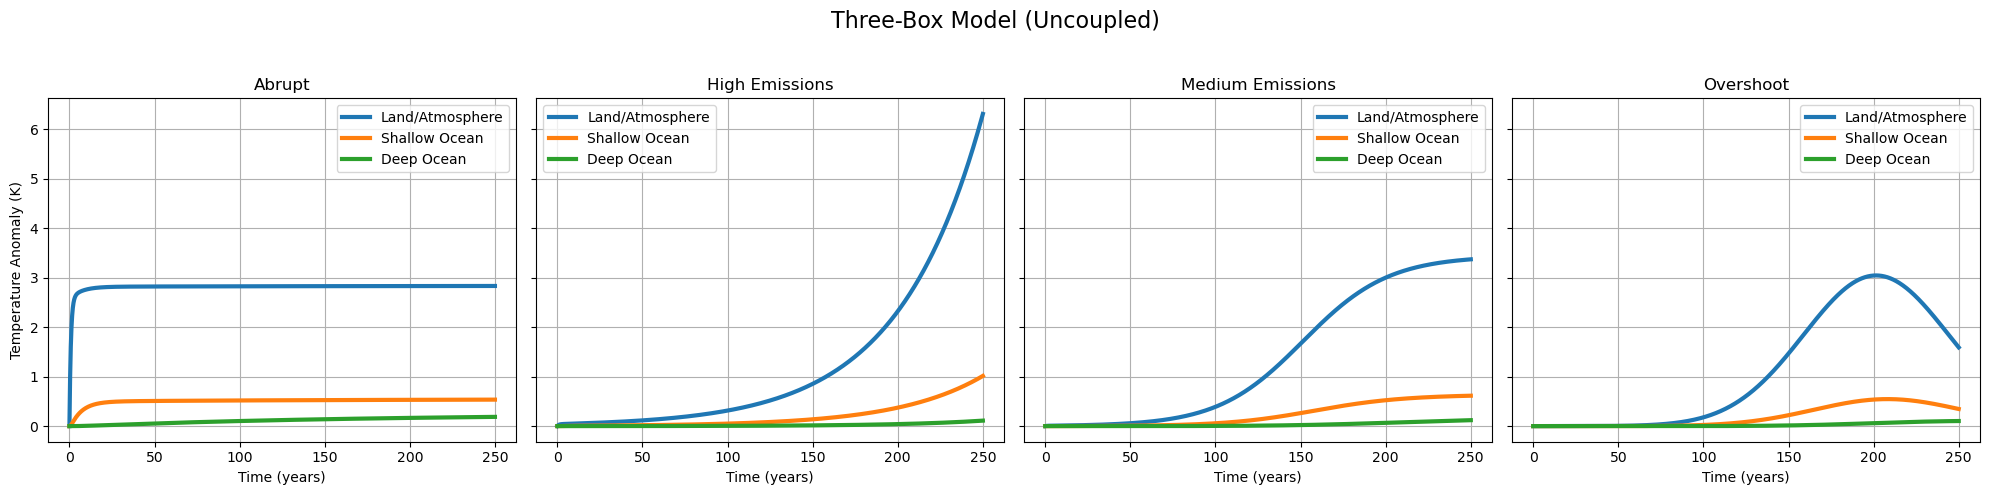

In [58]:
# --- Model Parameters for Three Boxes ---
# Climate feedback parameters (W m-2 K-1)
lam = np.array([0.86, 2.0, 0.67])

# Heat capacities (J/K/m^2)
h = np.array([10, 150, 1500])
C = h * rho_w * cp_w / sec_per_year 

# Diffusion coefficient
D = 0.55

# --- Three-Box Uncoupled Simulation ---
L_coupled = np.array([
    [-(lam[0] + D) / C[0], D / C[0], 0],
    [D / C[1], -(lam[1] + 2*D) / C[1], D / C[1]],
    [0, D / C[2], -(lam[2] + D) / C[2]]
])
T = np.zeros((3, len(t)))
results_uncoupled = []
dt = 0.1
for f in forcings:
    T_scenario = np.zeros((3, len(t)))
    F_vec = np.array([1, 0, 0]) # Forcing applied to all boxes for simplicity
    for i in range(1, len(t)):
        T_scenario[:, i] = T_scenario[:, i-1] + dt * (L_coupled @ T_scenario[:, i-1] + (F_vec * f[i-1]) / C)
    results_uncoupled.append(T_scenario)

# --- Plotting ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i in range(4):
    axes[i].plot(t, results_uncoupled[i][0, :], label='Land/Atmosphere', lw=3)
    axes[i].plot(t, results_uncoupled[i][1, :], label='Shallow Ocean', lw=3)
    axes[i].plot(t, results_uncoupled[i][2, :], label='Deep Ocean', lw=3)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Time (years)')
    if i == 0:
        axes[i].set_ylabel('Temperature Anomaly (K)')
    axes[i].grid(True)
    axes[i].legend()
plt.suptitle('Three-Box Model (Uncoupled)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()